In [67]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [59]:
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Point, Polygon
import xarray as xr
from datetime import datetime
from sklearn.neighbors import BallTree
import pyproj
from functools import partial
from rasterio.merge import merge

In [3]:
# === API Setup ===
URL = "https://api.contrails.org"
API_KEY = "6471544f41aff568ba1b3a530ecb8c3a"
HEADERS = {"x-api-key": API_KEY}

**Hypothesis 1: Contrail prediction from ERA5 humidity data is not fit Africa. ERA5 satellite coverage is limited to Europe. And we suspect that an interpolation is performed for predictions over Africa**

We are picking 10 random locations in Africa and performing contrail predictions solely relying on ERA5 data

In [ ]:
# === Locations to simulate flights over ===
locations = [
    {"name": "Nairobi_Kenya", "lat": -1.286389, "lon": 36.817223},
    {"name": "Cairo_Egypt", "lat": 30.044420, "lon": 31.235712},
    {"name": "Cape_Town_South_Africa", "lat": -33.924870, "lon": 18.424055},
    {"name": "Lagos_Nigeria", "lat": 6.524379, "lon": 3.379206},
    {"name": "Addis_Ababa_Ethiopia", "lat": 8.980603, "lon": 38.757759},
    {"name": "Marrakech_Morocco", "lat": 31.629472, "lon": -7.981084},
    {"name": "Kinshasa_DR_Congo", "lat": -4.441931, "lon": 15.266293},
    {"name": "Dar_es_Salaam_Tanzania", "lat": -6.792354, "lon": 39.208328},
    {"name": "Khartoum_Sudan", "lat": 15.500654, "lon": 32.559898},
    {"name": "Luanda_Angola", "lat": -8.839988, "lon": 13.289437}
]

# europe_locations = [
#     {"name": "Zurich, Switzerland", "lat": 47.3769, "lon": 8.5417},
#     {"name": "Konstanz, Germany", "lat": 47.6603, "lon": 9.1758},
#     {"name": "Venice, Italy", "lat": 45.4408, "lon": 12.3155}
# ]

In [24]:
# === Flight altitude profile from original example ===
altitude_profile = np.concatenate([
    np.linspace(0, 30000, 20),
    np.full(80, 30000),
    np.linspace(30000, 41000, 20),
    np.full(60, 41000),
    np.linspace(41000, 0, 20)
])
n_waypoints = len(altitude_profile)

# === Time Setup ===
t0 = datetime(2024, 11, 10, 10, 0, 0)
t1 = datetime(2024, 11, 10, 20, 20, 0)
timestamps = pd.date_range(t0, t1, periods=n_waypoints).astype(int) // 1_000_000_000

# === Collect all valid contrail data
all_contrails = []

# === Loop through locations ===
for loc in locations:
    name = loc["name"]
    lat = loc["lat"]
    lon = loc["lon"]
    print(f"✈️ Simulating flight over {name}...")

    # Create synthetic flight path: +/- 2.5 degrees in both directions
    lat_start = lat - 2.5
    lat_end = lat + 2.5
    lon_start = lon - 2.5
    lon_end = lon + 2.5

    fl = pd.DataFrame()
    fl["latitude"] = np.linspace(lat_start, lat_end, n_waypoints)
    fl["longitude"] = np.linspace(lon_start, lon_end, n_waypoints)
    fl["altitude"] = altitude_profile
    fl["time"] = timestamps

    payload = fl.to_dict("list") | {"aircraft_type": "B722"}

    try:
        r = requests.post(f"{URL}/v0/trajectory/cocip-contrail", json=payload, headers=HEADERS)
        print(f"HTTP Response Code: {r.status_code} {r.reason}")

        if r.status_code == 200:
            r_json = r.json()
            if "contrail" in r_json and r_json["contrail"]:
                contrail = pd.concat([pd.DataFrame(c) for c in r_json["contrail"] if c])
                contrail["time"] = pd.to_datetime(contrail["time"], unit="s")
                contrail["location"] = name
                all_contrails.append(contrail)
                print(f"✅ Contrails found: {len(contrail)} segments.\n")
            else:
                print(f"ℹ️ No contrails returned for {name}\n")
        else:
            print(f"❌ Failed to get contrail data for {name}: {r.text}\n")

    except Exception as e:
        print(f"❌ Exception for {name}: {e}\n")

# === Combine all results and save
if all_contrails:
    df_all = pd.concat(all_contrails, ignore_index=True)
    df_all.to_csv("contrail_synthetic_flights_all_locations.csv", index=False)
    print("📁 All contrail results saved to 'contrail_synthetic_flights_all_locations.csv'")
else:
    print("⚠️ No contrail data returned for any location.")


✈️ Simulating flight over Nairobi_Kenya...
HTTP Response Code: 200 OK
✅ Contrails found: 20 segments.

✈️ Simulating flight over Cairo_Egypt...
HTTP Response Code: 200 OK
❌ Exception for Cairo_Egypt: No objects to concatenate

✈️ Simulating flight over Cape_Town_South_Africa...
HTTP Response Code: 200 OK
✅ Contrails found: 55 segments.

✈️ Simulating flight over Lagos_Nigeria...
HTTP Response Code: 200 OK
✅ Contrails found: 2 segments.

✈️ Simulating flight over Addis_Ababa_Ethiopia...
HTTP Response Code: 200 OK
✅ Contrails found: 3 segments.

✈️ Simulating flight over Marrakech_Morocco...
HTTP Response Code: 200 OK
✅ Contrails found: 9 segments.

✈️ Simulating flight over Kinshasa_DR_Congo...
HTTP Response Code: 200 OK
✅ Contrails found: 2 segments.

✈️ Simulating flight over Dar_es_Salaam_Tanzania...
HTTP Response Code: 200 OK
✅ Contrails found: 19 segments.

✈️ Simulating flight over Khartoum_Sudan...
HTTP Response Code: 200 OK
✅ Contrails found: 12 segments.

✈️ Simulating flight o

Load, explore and analyse prediction results

In [26]:
# === Load Data ===
df = pd.read_csv("/kaggle/working/contrail_synthetic_flights_all_locations.csv")

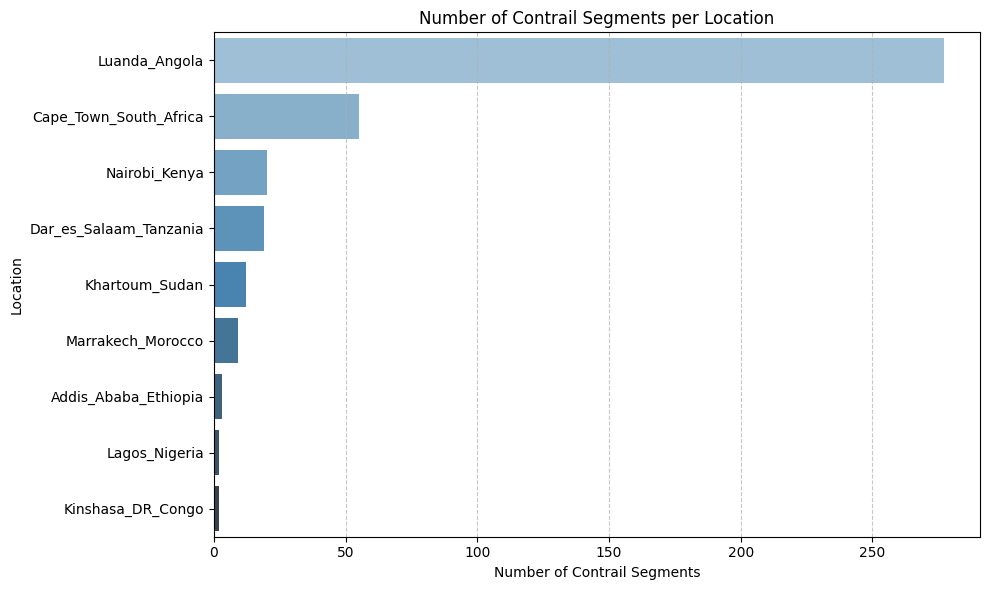

In [27]:
# === Step 1: Summary — Count Contrails per Location ===
location_counts = df["location"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=location_counts.values, y=location_counts.index, palette="Blues_d")
plt.title("Number of Contrail Segments per Location")
plt.xlabel("Number of Contrail Segments")
plt.ylabel("Location")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

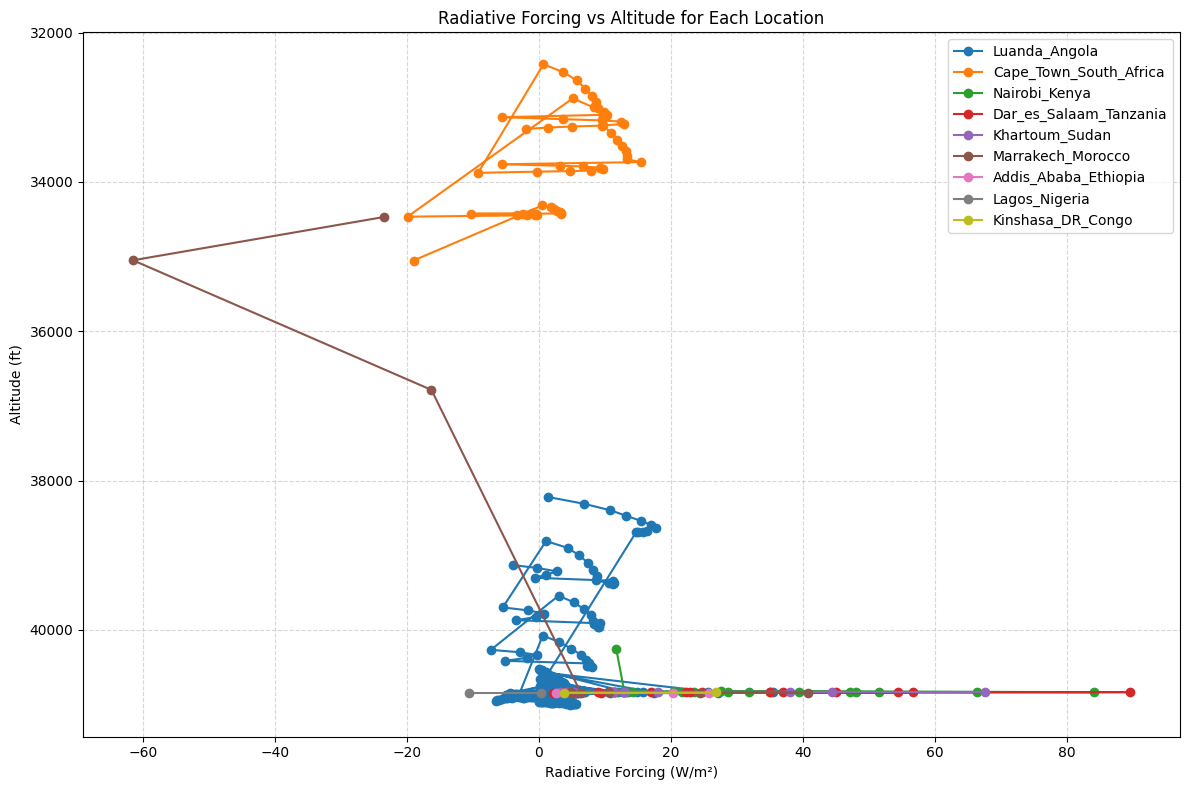

In [28]:
# === Step 2: Radiative Forcing vs Altitude ===
df["rf_total"] = df["rf_sw"].fillna(0) + df["rf_lw"].fillna(0)

top_locations = df["location"].value_counts()[df["location"].value_counts() > 0].index.tolist()

plt.figure(figsize=(12, 8))
for loc in top_locations:
    subset = df[df["location"] == loc]
    plt.plot(subset["rf_total"], subset["altitude"], marker="o", linestyle='-', label=loc)

plt.gca().invert_yaxis()
plt.title("Radiative Forcing vs Altitude for Each Location")
plt.xlabel("Radiative Forcing (W/m²)")
plt.ylabel("Altitude (ft)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

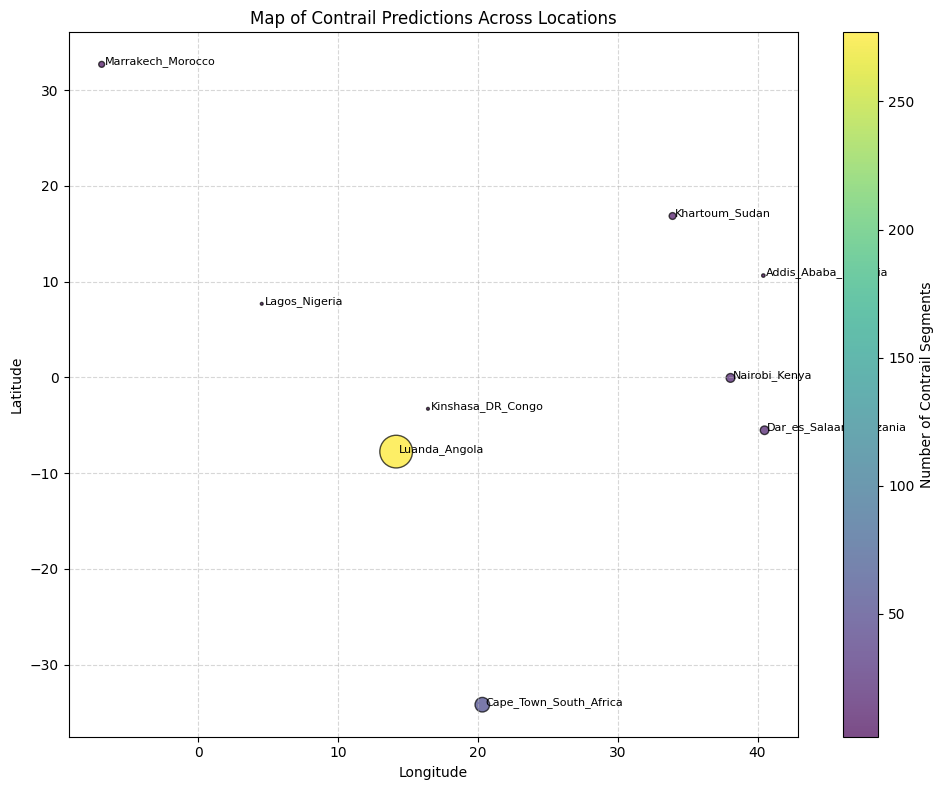

In [29]:
# === Step 3: Map-Style Scatterplot ===
location_coords = df.groupby("location")[["latitude", "longitude"]].mean().reset_index()
location_counts = df["location"].value_counts().reset_index()
location_counts.columns = ["location", "count"]

location_map = pd.merge(location_coords, location_counts, on="location")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    location_map["longitude"],
    location_map["latitude"],
    s=location_map["count"] * 2,
    c=location_map["count"],
    cmap="viridis",
    alpha=0.7,
    edgecolor="k"
)
for i, row in location_map.iterrows():
    plt.text(row["longitude"] + 0.2, row["latitude"], row["location"], fontsize=8)

plt.colorbar(scatter, label="Number of Contrail Segments")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Map of Contrail Predictions Across Locations")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Comparison with Predictions over European cities

In [31]:
# Define European locations (existing + 7 new ones)
europe_locations = [
    {"name": "Zurich_Switzerland", "lat": 47.3769, "lon": 8.5417},
    {"name": "Konstanz_Germany", "lat": 47.6603, "lon": 9.1758},
    {"name": "Venice_Italy", "lat": 45.4408, "lon": 12.3155},
    {"name": "Paris_France", "lat": 48.8566, "lon": 2.3522},
    {"name": "Madrid_Spain", "lat": 40.4168, "lon": -3.7038},
    {"name": "Rome_Italy", "lat": 41.9028, "lon": 12.4964},
    {"name": "Berlin_Germany", "lat": 52.5200, "lon": 13.4050},
    {"name": "Oslo_Norway", "lat": 59.9139, "lon": 10.7522},
    {"name": "Amsterdam_Netherlands", "lat": 52.3676, "lon": 4.9041},
    {"name": "Vienna_Austria", "lat": 48.2082, "lon": 16.3738}
    
]

# Reuse flight profile and timestamp logic
altitude_profile = np.concatenate([
    np.linspace(0, 30000, 20),
    np.full(80, 30000),
    np.linspace(30000, 39000, 20),
    np.full(60, 39000),
    np.linspace(39000, 0, 20)
])
n_waypoints = len(altitude_profile)
t0 = datetime(2024, 11, 10, 10, 0, 0)
t1 = datetime(2024, 11, 10, 20, 20, 0)
timestamps = pd.date_range(t0, t1, periods=n_waypoints).astype(int) // 1_000_000_000

# Container for all results
europe_contrails = []

# Loop through new European locations
for loc in europe_locations:
    name = loc["name"]
    lat = loc["lat"]
    lon = loc["lon"]
    print(f"✈️ Simulating flight over {name}...")

    lat_start = lat - 2.5
    lat_end = lat + 2.5
    lon_start = lon - 2.5
    lon_end = lon + 2.5

    fl = pd.DataFrame()
    fl["latitude"] = np.linspace(lat_start, lat_end, n_waypoints)
    fl["longitude"] = np.linspace(lon_start, lon_end, n_waypoints)
    fl["altitude"] = altitude_profile
    fl["time"] = timestamps

    payload = fl.to_dict("list") | {"aircraft_type": "B722"}

    try:
        r = requests.post(f"{URL}/v0/trajectory/cocip-contrail", json=payload, headers=HEADERS)
        print(f"HTTP Response Code: {r.status_code} {r.reason}")

        if r.status_code == 200:
            r_json = r.json()
            if "contrail" in r_json and r_json["contrail"]:
                contrail = pd.concat([pd.DataFrame(c) for c in r_json["contrail"] if c])
                contrail["time"] = pd.to_datetime(contrail["time"], unit="s")
                contrail["location"] = name
                europe_contrails.append(contrail)
                print(f"✅ Contrails found: {len(contrail)} segments.\n")
            else:
                print(f"ℹ️ No contrails returned for {name}\n")
        else:
            print(f"❌ Failed to get contrail data for {name}: {r.text}\n")

    except Exception as e:
        print(f"❌ Exception for {name}: {e}\n")

# Combine and save results
if europe_contrails:
    df_europe = pd.concat(europe_contrails, ignore_index=True)
    df_europe.to_csv("contrail_synthetic_flights_europe_locations.csv", index=False)
    print("📁 European contrail results saved to 'contrail_synthetic_flights_europe_locations.csv'")
else:
    print("⚠️ No contrail data returned for European locations.")


✈️ Simulating flight over Zurich_Switzerland...
HTTP Response Code: 200 OK
✅ Contrails found: 27 segments.

✈️ Simulating flight over Konstanz_Germany...
HTTP Response Code: 200 OK
✅ Contrails found: 32 segments.

✈️ Simulating flight over Venice_Italy...
HTTP Response Code: 200 OK
✅ Contrails found: 90 segments.

✈️ Simulating flight over Paris_France...
HTTP Response Code: 200 OK
✅ Contrails found: 42 segments.

✈️ Simulating flight over Madrid_Spain...
HTTP Response Code: 200 OK
✅ Contrails found: 6 segments.

✈️ Simulating flight over Rome_Italy...
HTTP Response Code: 200 OK
✅ Contrails found: 82 segments.

✈️ Simulating flight over Berlin_Germany...
HTTP Response Code: 200 OK
✅ Contrails found: 30 segments.

✈️ Simulating flight over Oslo_Norway...
HTTP Response Code: 200 OK
✅ Contrails found: 972 segments.

✈️ Simulating flight over Amsterdam_Netherlands...
HTTP Response Code: 200 OK
✅ Contrails found: 19 segments.

✈️ Simulating flight over Vienna_Austria...
HTTP Response Code: 

Load, explore and analyse prediction results for Europe

In [33]:
# === Load the European predictions ===
df_europe = pd.read_csv("/kaggle/working/contrail_synthetic_flights_europe_locations.csv")

# === Add total radiative forcing column ===
df_europe["rf_total"] = df_europe["rf_sw"].fillna(0) + df_europe["rf_lw"].fillna(0)

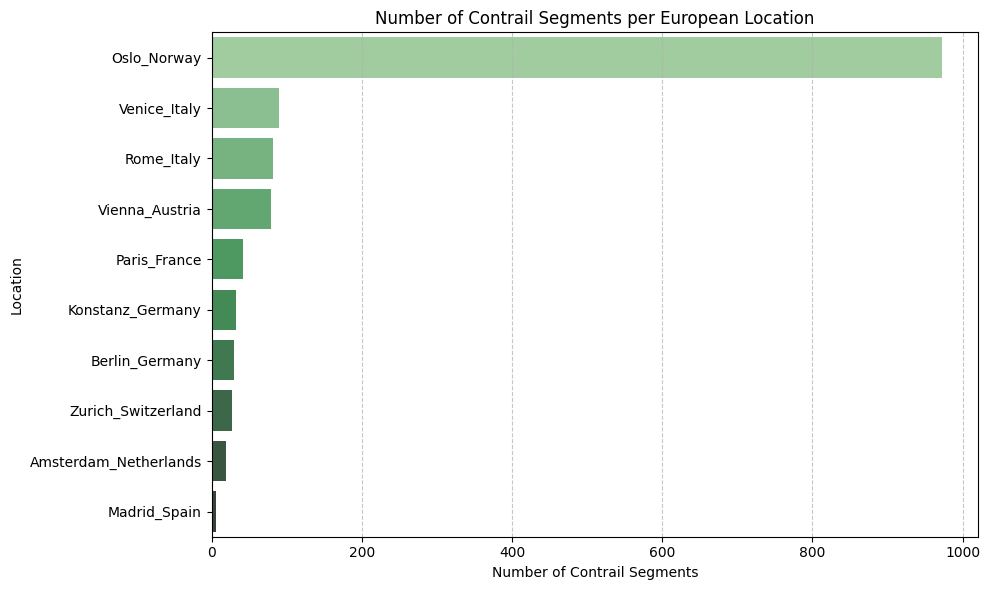

In [34]:
# === Step 1: Contrail Segment Count per City ===
europe_counts = df_europe["location"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=europe_counts.values, y=europe_counts.index, palette="Greens_d")
plt.title("Number of Contrail Segments per European Location")
plt.xlabel("Number of Contrail Segments")
plt.ylabel("Location")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

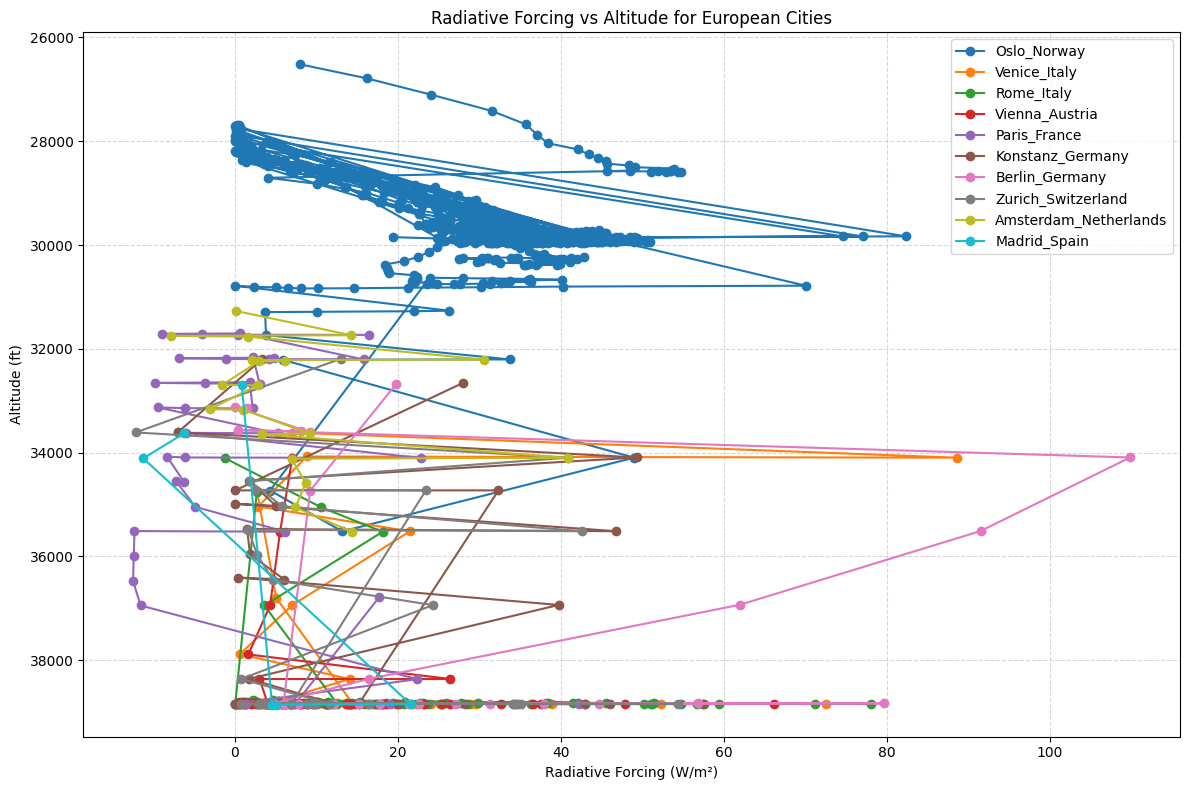

In [35]:
# === Step 2: Radiative Forcing vs Altitude ===
top_europe_locs = europe_counts.index.tolist()

plt.figure(figsize=(12, 8))
for loc in top_europe_locs:
    subset = df_europe[df_europe["location"] == loc]
    plt.plot(subset["rf_total"], subset["altitude"], marker="o", linestyle='-', label=loc)

plt.gca().invert_yaxis()
plt.title("Radiative Forcing vs Altitude for European Cities")
plt.xlabel("Radiative Forcing (W/m²)")
plt.ylabel("Altitude (ft)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


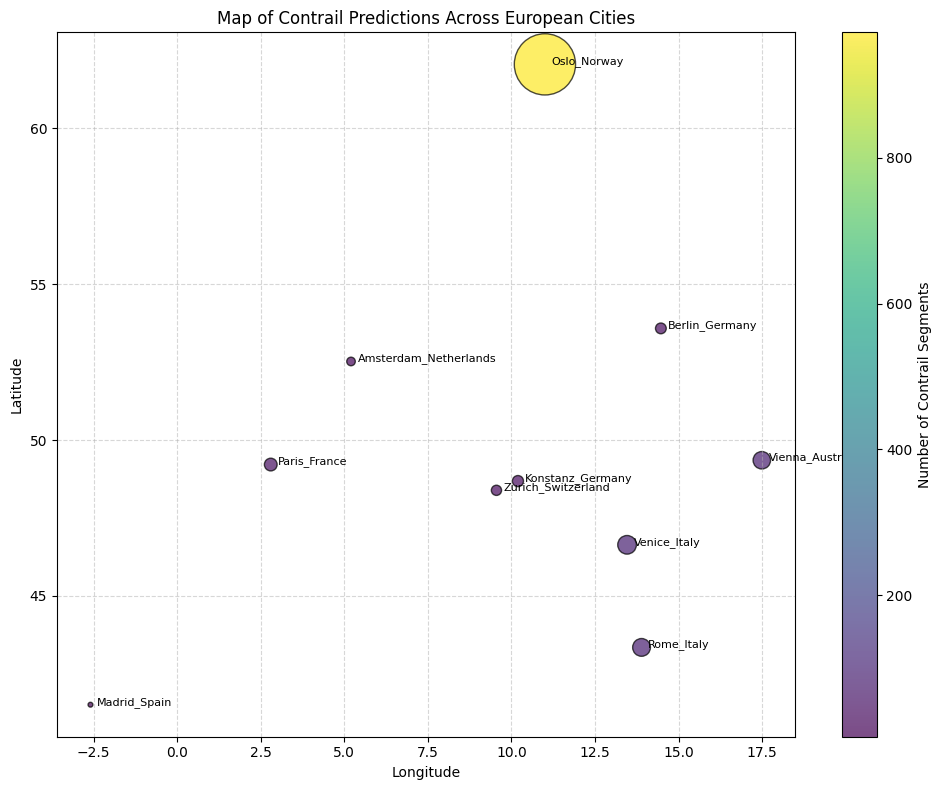

In [36]:
# === Step 3: Map-Style Visualization ===
location_coords = df_europe.groupby("location")[["latitude", "longitude"]].mean().reset_index()
location_counts = df_europe["location"].value_counts().reset_index()
location_counts.columns = ["location", "count"]

europe_map = pd.merge(location_coords, location_counts, on="location")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    europe_map["longitude"],
    europe_map["latitude"],
    s=europe_map["count"] * 2,
    c=europe_map["count"],
    cmap="viridis",
    alpha=0.7,
    edgecolor="k"
)
for _, row in europe_map.iterrows():
    plt.text(row["longitude"] + 0.2, row["latitude"], row["location"], fontsize=8)

plt.colorbar(scatter, label="Number of Contrail Segments")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Map of Contrail Predictions Across European Cities")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

<ipython-input-52-50584bc4137e>:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


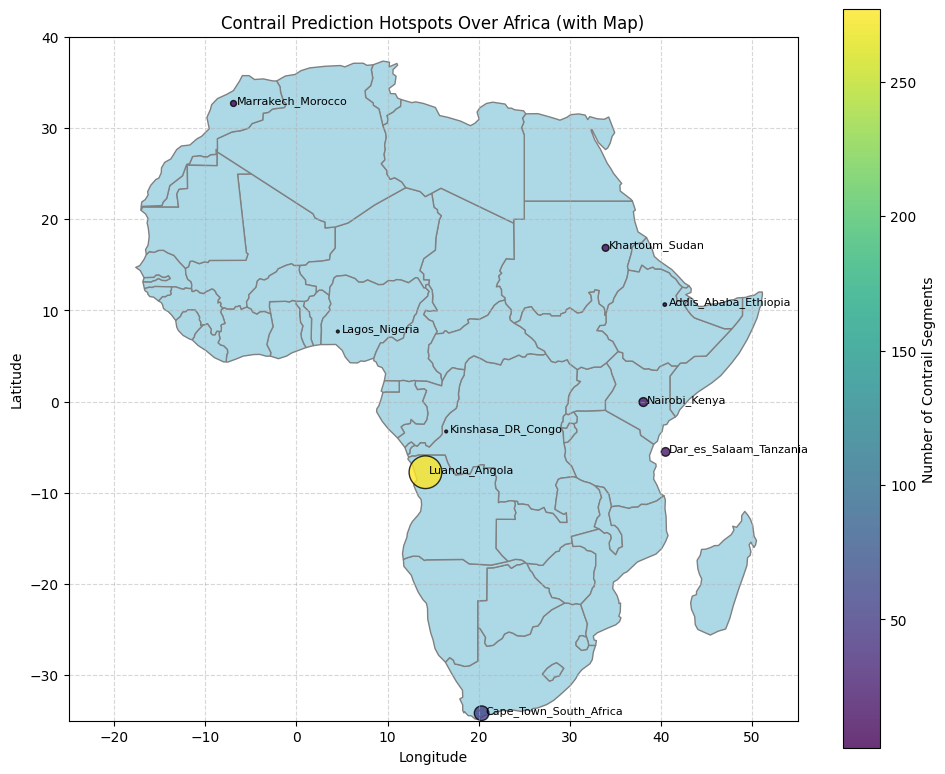

In [52]:
import geopandas as gpd


# Load African contrail prediction data
df_africa = pd.read_csv("/kaggle/working/contrail_synthetic_flights_all_locations.csv")

# Group and count by location
location_map = df_africa.groupby("location")[["latitude", "longitude"]].mean().reset_index()
location_counts = df_africa["location"].value_counts().reset_index()
location_counts.columns = ["location", "count"]
location_map = pd.merge(location_map, location_counts, on="location")

# Load world map and filter to Africa only
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
africa = world[world['continent'] == 'Africa'].copy()

# Plot Africa map
fig, ax = plt.subplots(figsize=(10, 8))
africa.plot(ax=ax, color='lightblue', edgecolor='gray')

# Overlay city markers
scatter = ax.scatter(
    location_map["longitude"],
    location_map["latitude"],
    s=location_map["count"] * 2,
    c=location_map["count"],
    cmap="viridis",
    alpha=0.8,
    edgecolor="black"
)

# Add city name labels
for _, row in location_map.iterrows():
    ax.text(row["longitude"] + 0.4, row["latitude"], row["location"], fontsize=8)

# Set Africa view bounds
ax.set_xlim(-25, 55)
ax.set_ylim(-35, 40)

# Final map styling
plt.colorbar(scatter, label="Number of Contrail Segments")
plt.title("Contrail Prediction Hotspots Over Africa (with Map)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

<ipython-input-49-00a03b7fcb9b>:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


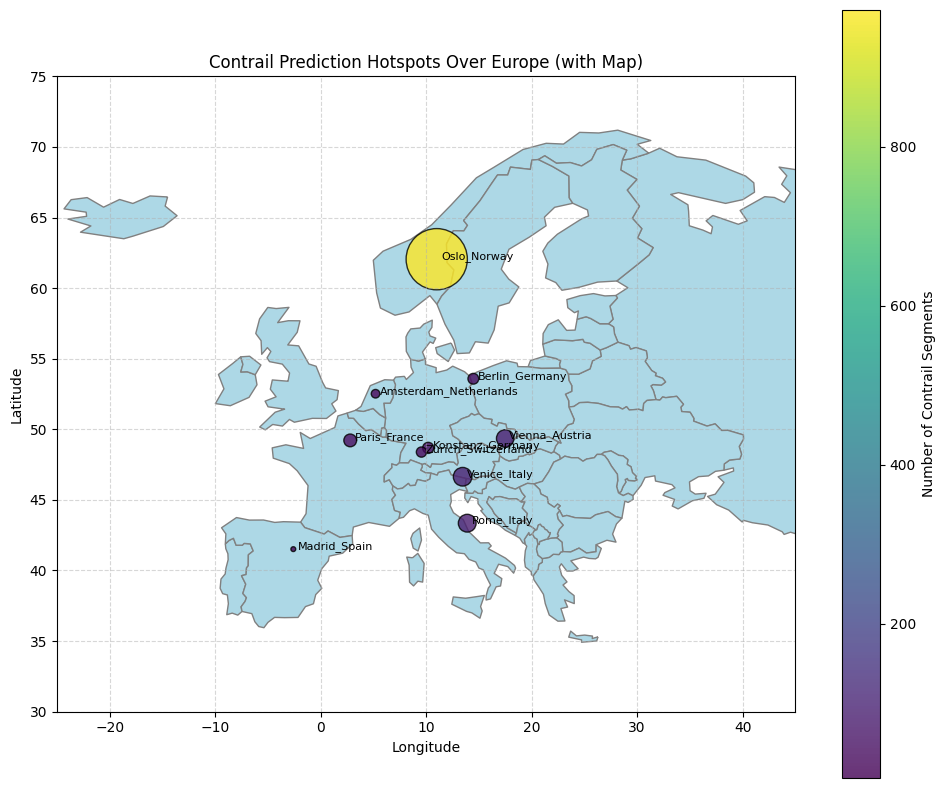

In [49]:
# Group and count by location
location_map = df_europe.groupby("location")[["latitude", "longitude"]].mean().reset_index()
location_counts = df_europe["location"].value_counts().reset_index()
location_counts.columns = ["location", "count"]
location_map = pd.merge(location_map, location_counts, on="location")

# Load world basemap and filter to Europe using continent info
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
europe = world[world['continent'] == 'Europe'].copy()

# Plot map
fig, ax = plt.subplots(figsize=(10, 8))
europe.plot(ax=ax, color='lightblue', edgecolor='gray')

# Overlay city contrail counts
scatter = ax.scatter(
    location_map["longitude"],
    location_map["latitude"],
    s=location_map["count"] * 2,
    c=location_map["count"],
    cmap="viridis",
    alpha=0.8,
    edgecolor="black"
)

# Add city labels
for _, row in location_map.iterrows():
    ax.text(row["longitude"] + 0.4, row["latitude"], row["location"], fontsize=8)

# Focus on Europe
ax.set_xlim(-25, 45)
ax.set_ylim(30, 75)

# Final plot touches
plt.colorbar(scatter, label="Number of Contrail Segments")
plt.title("Contrail Prediction Hotspots Over Europe (with Map)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

**Hypothesis 2: Environmental factors can be relied on to infer humidity for areas of Africa that are not well represented by the ERA5 data set due to limited satellite coverage and ground meteorological observations**

A class that loads envrionmental factors datasets and generates the relevant indincies

In [60]:
class EnvironmentalDataLoader:
    def __init__(self):
        # File paths
        self.water_bodies_path = ['/kaggle/input/contrail-prediction-dataset/internal_waters/internal_waters/eez_internal_waters_v4.shp',
                     '/kaggle/input/contrail-prediction-dataset/oceeans/goas_v01.shp']             
        self.land_cover_path = '/kaggle/input/input-corine-land-cover/jrc-luisa-input-corine-land-cover-2006-r-ref-2014-zip/LUISA_CLC/clc06_r.tif'
        self.elevation_paths = [
            '/kaggle/input/europe-dem-aoi/10_DEM_y40x0.tif',
            '/kaggle/input/europe-dem-aoi/10_DEM_y40x10.tif'
        ]

        # Internal state
        self.water_bodies_proj = None
        self.land_cover = None
        self.elevation_datasets = []
        self.transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

        # Load all
        self.load_all()

    def load_all(self):
        self._load_water_bodies()
        self._load_land_cover()
        self._load_elevation_data()

    def _load_water_bodies(self):
        try:
            water_layers = []
    
            for path in self.water_bodies_path:
                layer = gpd.read_file(path)
                layer = layer.to_crs(epsg=3857)  # Project to Web Mercator
                water_layers.append(layer)
    
            # Merge all water features into one GeoDataFrame
            self.water_bodies_proj = gpd.GeoDataFrame(pd.concat(water_layers, ignore_index=True), crs="EPSG:3857")
            print("✅ All water bodies (internal + ocean) loaded and merged")
    
        except Exception as e:
            print(f"❌ Failed to load water bodies: {e}")

    def _load_land_cover(self):
        try:
            self.land_cover = rasterio.open(self.land_cover_path)
            print("✅ Land cover loaded")
        except Exception as e:
            print(f"❌ Failed to load land cover: {e}")

    def _load_elevation_data(self):
        try:
            # Open all DEM files
            src_files = [rasterio.open(path) for path in self.elevation_paths]
    
            # Merge into one dataset
            mosaic, out_transform = merge(src_files)
    
            # Save internal references
            self.elevation = mosaic
            self.elevation_meta = src_files[0].meta.copy()
            self.elevation_meta.update({
                "height": mosaic.shape[1],
                "width": mosaic.shape[2],
                "transform": out_transform
            })
    
            print("✅ Elevation tiles merged into one raster")

        except Exception as e:
            print(f"❌ Failed to merge elevation data: {e}")

    def get_water_proximity(self, lat, lon):
        try:
            point = Point(*self.transformer.transform(lon, lat))
            if self.water_bodies_proj is not None:
                dists = self.water_bodies_proj.distance(point)
                min_dist = dists.min()
                return float(np.exp(-min_dist / 50000))  # normalize
            return 0.0
        except Exception as e:
            print(f"Error in water proximity: {e}")
            return 0.0

    def get_forest_density(self, lat, lon):
        try:
            if self.land_cover is None:
                return 0.0
            row, col = self.land_cover.index(lon, lat)
            value = self.land_cover.read(1)[row, col]
            return 1.0 if value in [311, 312, 313] else 0.0  # Corine forest classes
        except Exception as e:
            print(f"Error in forest density: {e}")
            return 0.0

    def get_elevation(self, lat, lon):
        try:
            # Convert (lon, lat) to raster row/col
            row, col = rasterio.transform.rowcol(self.elevation_meta["transform"], lon, lat)
            if 0 <= row < self.elevation.shape[1] and 0 <= col < self.elevation.shape[2]:
                elev = self.elevation[0, row, col]
                if -100 <= elev <= 9000:
                    return float(elev)
        except Exception as e:
            print(f"Error in elevation query: {e}")
        return 0.0

# Initialize loader
loader = EnvironmentalDataLoader()


✅ All water bodies (internal + ocean) loaded and merged
✅ Land cover loaded
✅ Elevation tiles merged into one raster


In [61]:
class EnvironmentalPredictor:
    def __init__(self, env_loader):
        self.env_loader = env_loader

    def get_seasonal_factors(self, lat, lon, date):
        """
        Determine if it's wet season and calculate monthly seasonal factor
        """
        if isinstance(date, str):
            date = pd.to_datetime(date)

        month = date.month
        is_wet_season = 0

        if lat > 0:
            if 5 <= month <= 10:
                is_wet_season = 1
        else:
            if month <= 4 or month >= 11:
                is_wet_season = 1

        # Sinusoidal seasonality factor
        if lat > 0:
            monthly_factor = np.sin(np.pi * (month - 1) / 11.0)
        else:
            monthly_factor = np.sin(np.pi * (month - 7) / 11.0)

        monthly_factor = (monthly_factor + 1) / 2
        return is_wet_season, monthly_factor

    def predict_rhi(self, lat, lon, flight_level, date="2023-11-10"):
        """
        Predict Relative Humidity with respect to ice (RHi) using environmental factors
        """
        date = pd.to_datetime(date)
        altitude_m = flight_level * 30.48

        # Environmental factors
        water_proximity = self.env_loader.get_water_proximity(lat, lon)
        forest_density = self.env_loader.get_forest_density(lat, lon)
        elevation = self.env_loader.get_elevation(lat, lon)
        is_wet_season, monthly_factor = self.get_seasonal_factors(lat, lon, date)

        # Estimate base RHi from pressure level
        base_humidity = max(0.2, 1.0 - (flight_level / 400.0))

        # Combine features into prediction
        humidity = (
            base_humidity +
            0.3 * water_proximity +
            0.2 * forest_density +
            0.1 * np.exp(-elevation / 5000) +
            0.15 * is_wet_season +
            0.1 * monthly_factor
        )

        # Apply tropospheric U-shape humidity modulation
        tropo_effect = np.exp(-(altitude_m - 11000)**2 / 20000000)
        humidity *= tropo_effect

        return np.clip(humidity, 0.1, 1.2)

    def predict_contrail(self, rhi, temp_c=-50):
        """
        Predict contrail formation using Schmidt-Appleman Criterion (simplified)
        """
        T_crit = -40  # Conservative threshold for contrail formation
        forms_initially = temp_c < T_crit
        is_persistent = rhi >= 1.0
        return {
            "contrail_forms": forms_initially and is_persistent,
            "initially_persistent": is_persistent,
            "forms_initially": forms_initially,
            "rhi": rhi,
            "temperature": temp_c
        }

In [65]:
predictor = EnvironmentalPredictor(loader)

In [62]:
class ContrailComparisonAnalyzer:
    def __init__(self, predictor, env_loader, output_dir="results"):
        self.predictor = predictor
        self.env_loader = env_loader
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

    def analyze_location(self, location, flight_levels, date="2023-11-10"):
        lat, lon = location["lat"], location["lon"]
        location_name = location["name"]

        records = []
        for fl in flight_levels:
            rhi = self.predictor.predict_rhi(lat, lon, fl, date)

            # Estimate temp (simplified ISA lapse rate)
            alt_m = fl * 30.48
            temp_c = 15 - 0.0065 * alt_m

            prediction = self.predictor.predict_contrail(rhi, temp_c)

            records.append({
                "location": location_name,
                "lat": lat,
                "lon": lon,
                "flight_level": fl,
                "rhi": prediction["rhi"],
                "temp_c": temp_c,
                "contrail_forms": prediction["contrail_forms"],
                "forms_initially": prediction["forms_initially"],
                "initially_persistent": prediction["initially_persistent"],
                "water_proximity": self.env_loader.get_water_proximity(lat, lon),
                "forest_density": self.env_loader.get_forest_density(lat, lon),
                "elevation": self.env_loader.get_elevation(lat, lon),
            })
        return pd.DataFrame(records)

    def analyze_all(self, africa_locations, europe_locations, flight_levels, date="2023-11-10"):
        dfs = []
        for region, locations in [("Africa", africa_locations), ("Europe", europe_locations)]:
            for loc in locations:
                df = self.analyze_location(loc, flight_levels, date)
                df["region"] = region
                dfs.append(df)
        combined = pd.concat(dfs, ignore_index=True)
        combined.to_csv(os.path.join(self.output_dir, "env_factor_predictions.csv"), index=False)
        return combined

    def plot_rhi_profiles(self, df):
        for location in df["location"].unique():
            sub = df[df["location"] == location]
            plt.figure(figsize=(8, 5))
            plt.plot(sub["flight_level"], sub["rhi"], marker='o', label="Environmental RHi")
            plt.axhline(1.0, ls="--", color="red", label="Contrail Threshold")
            plt.title(f"RHi Profile - {location}")
            plt.xlabel("Flight Level")
            plt.ylabel("RHi")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, f"rhi_profile_{location.replace(',', '').replace(' ', '_')}.png"))
            plt.close()

    def plot_feature_influence(self, df):
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        axes[0].scatter(df["water_proximity"], df["rhi"], alpha=0.6, c=df["region"].map({"Africa": "blue", "Europe": "green"}))
        axes[0].set_title("Water Proximity vs RHi")
        axes[1].scatter(df["forest_density"], df["rhi"], alpha=0.6, c=df["region"].map({"Africa": "blue", "Europe": "green"}))
        axes[1].set_title("Forest Density vs RHi")
        axes[2].scatter(df["elevation"], df["rhi"], alpha=0.6, c=df["region"].map({"Africa": "blue", "Europe": "green"}))
        axes[2].set_title("Elevation vs RHi")
        for ax in axes:
            ax.set_xlabel("Feature Value")
            ax.set_ylabel("RHi")
            ax.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "feature_influence_rhi.png"))
        plt.close()

    def plot_contrail_maps(self, df):
        fig, ax = plt.subplots(figsize=(12, 8))
        grouped = df.groupby("location").agg({
            "lat": "first",
            "lon": "first",
            "contrail_forms": "sum"
        }).reset_index()
        scatter = ax.scatter(grouped["lon"], grouped["lat"],
                             s=grouped["contrail_forms"]*10,
                             c=grouped["contrail_forms"],
                             cmap="coolwarm", alpha=0.8, edgecolor="k")
        for _, row in grouped.iterrows():
            ax.text(row["lon"] + 0.3, row["lat"], row["location"], fontsize=8)
        plt.colorbar(scatter, label="Contrail Formation Count")
        ax.set_title("Contrail Predictions by Location")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "contrail_prediction_map.png"))
        plt.close()

In [68]:
analyzer = ContrailComparisonAnalyzer(predictor, loader)

In [ ]:
# Analyze all cities
df_results = analyzer.analyze_all(africa_locations, europe_locations, flight_levels)

In [12]:
analyzer.plot_rhi_profiles(df_results)
analyzer.plot_feature_influence(df_results)
analyzer.plot_contrail_maps(df_results)